# Feature Engineering y data enrichment

## Enriquecimiento del dataset

### Descargar datos desde api 

Instalamos librerías necesarias para Open-Meteo

In [3]:
!pip install openmeteo-requests requests-cache retry-requests

   ---------------------------------------- 0.0/670.9 kB ? eta -:--:--
   ---------------------------------------- 670.9/670.9 kB 4.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   --------------- ------------------------ 0.8/2.0 MB 4.2 MB/s eta 0:00:01
   ------------------------------- -------- 1.6/2.0 MB 3.7 MB/s eta 0:00:01
   ---------------------------------------- 2.0/2.0 MB 3.5 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
Importamos librerias y datos necesarios

In [1]:
import pandas as pd

# --- 1. Carga del Dataset Base ---
ruta_dataset = "../data/processed/dataset_final_etiquetado.csv"
df = pd.read_csv(ruta_dataset)
df['date'] = pd.to_datetime(df['date']) # Muy importante para manipular fechas

print("✅ Dataset base cargado exitosamente.")
print(f"Dimensiones iniciales: {df.shape}")

# --- 2. Ingeniería de Características (Feature Engineering) ---

# --- Características Temporales ---
df['año'] = df['date'].dt.year
df['mes'] = df['date'].dt.month
df['dia_del_año'] = df['date'].dt.dayofyear # El número de día del 1 al 365

# --- Característica de Interacción ---
df['rango_temp_diario'] = df['TMAX'] - df['TMIN']

print("\n✅ Nuevas características creadas:")
# Mostramos el resultado con las nuevas columnas al final
display(df[['date', 'año', 'mes', 'dia_del_año', 'rango_temp_diario', 'granizo']].head())

✅ Dataset base cargado exitosamente.
Dimensiones iniciales: (37399, 8)

✅ Nuevas características creadas:


,date,año,mes,dia_del_año,rango_temp_diario,granizo
0,2000-01-01,2000,1,1,NaN,0
1,2000-01-01,2000,1,1,15.8,1
2,2000-01-01,2000,1,1,NaN,0
3,2000-01-01,2000,1,1,15.8,0
4,2000-01-02,2000,1,2,17.5,0


Cargamos el dataset y mostramos unas nuevas características agregadas, día del año y rango de temperatura diario.
La intención es tener la mayor cantidad de datos disponibles para un análisis más exhaustivo y ver que patrones podemos encontrar.

Veremos el resultado del nuevo df

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37399 entries, 0 to 37398
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               37399 non-null  datetime64[ns]
 1   station_name       37399 non-null  object        
 2   PRCP               9668 non-null   float64       
 3   SNWD               225 non-null    float64       
 4   TAVG               37397 non-null  float64       
 5   TMAX               19599 non-null  float64       
 6   TMIN               35148 non-null  float64       
 7   granizo            37399 non-null  int64         
 8   año                37399 non-null  int32         
 9   mes                37399 non-null  int32         
 10  dia_del_año        37399 non-null  int32         
 11  rango_temp_diario  18324 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int32(3), int64(1), object(1)
memory usage: 3.0+ MB


Prueba de api - Comparación de estaciones vs. obtenidas por API

In [7]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry

# --- 1. Configuración ---
# (Asumimos que el cliente de Open-Meteo ya está configurado en una celda anterior)
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# --- 2. Nuestros datos de estaciones (ahora con la elevación conocida) ---
stations_info_data = {
    'station_name': [
        'MENDOZA AERO, AR', 'SAN MARTIN, AR', 'MENDOZA OBSERVATORIO, AR', 
        'MALARGUE, AR', 'SAN RAFAEL, AR'
    ],
    'latitude': [-32.83, -33.08, -32.9, -35.48, -34.58],
    'longitude': [-68.78, -68.48, -68.87, -69.58, -68.33],
    'elevation_conocida': [704, 653, 827, 1425, 748] # Elevación en metros
}
stations_info_df = pd.DataFrame(stations_info_data)

print("--- Verificando Coordenadas con la API de Open-Meteo ---")
print("Estación                       | Elevación Conocida | Elevación API (Modelo)")
print("-------------------------------|--------------------|------------------------")

# --- 3. Bucle de Verificación ---
for index, station in stations_info_df.iterrows():
    params = {
        "latitude": station['latitude'],
        "longitude": station['longitude'],
        "daily": "temperature_2m_max", # Pedimos cualquier variable para obtener la metadata
        "start_date": "2024-01-01",
        "end_date": "2024-01-01"
    }
    
    try:
        responses = openmeteo.weather_api("https://archive-api.open-meteo.com/v1/archive", params=params)
        response = responses[0]
        
        # Obtenemos la elevación de la respuesta de la API
        elevation_api = response.Elevation()
        
        # Imprimimos la comparación
        print(f"{station['station_name']:<30} | {station['elevation_conocida']:>18}m | {elevation_api:.2f}m")
        
    except Exception as e:
        print(f"Error al verificar {station['station_name']}: {e}")

--- Verificando Coordenadas con la API de Open-Meteo ---
Estación                       | Elevación Conocida | Elevación API (Modelo)
-------------------------------|--------------------|------------------------
MENDOZA AERO, AR               |                704m | 701.00m
SAN MARTIN, AR                 |                653m | 661.00m
MENDOZA OBSERVATORIO, AR       |                827m | 830.00m
MALARGUE, AR                   |               1425m | 1418.00m
SAN RAFAEL, AR                 |                748m | 691.00m


Enriquecimiento del dataset

In [22]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
import time
import os
import calendar

# --- 1. Cargar y preparar el dataset base ---
ruta_dataset = "../data/processed/dataset_final_etiquetado.csv"
df_base = pd.read_csv(ruta_dataset)
df_base['date'] = pd.to_datetime(df_base['date'])
stations_info_data = {
    'station_name': ['MENDOZA AERO, AR', 'SAN MARTIN, AR', 'MENDOZA OBSERVATORIO, AR', 'MALARGUE, AR', 'SAN RAFAEL, AR'],
    'latitude': [-32.83, -33.08, -32.9, -35.48, -34.58],
    'longitude': [-68.78, -68.48, -68.87, -69.58, -68.33]
}
stations_info_df = pd.DataFrame(stations_info_data)
df_base = pd.merge(df_base, stations_info_df, on='station_name', how='left')

# --- 2. Configurar el cliente de la API ---
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)
print("✅ Cliente de API listo.")

# --- 3. Función de Enriquecimiento (con rango de años fijo) ---
def enriquecer_estacion_final(df_estacion):
    if df_estacion.empty: return pd.DataFrame()
    lat, lon = df_estacion['latitude'].iloc[0], df_estacion['longitude'].iloc[0]
    
    # === CAMBIO CLAVE AQUÍ ===
    # Forzamos el rango de años a ser siempre 2000-2024.
    start_year, end_year = 2000, 2024
    
    lista_df_obtenidos = []
    print(f"  -> Procesando años desde {start_year} hasta {end_year}...")
    
    # ... (el resto de la función es exactamente igual que la versión "quirúrgica" anterior) ...
    for year in range(start_year, end_year + 1):
        try:
            params_anual = { "latitude": lat, "longitude": lon, "start_date": f"{year}-01-01", "end_date": f"{year}-12-31", "daily": ["weather_code", "temperature_2m_max", "temperature_2m_min", "apparent_temperature_mean", "precipitation_sum", "rain_sum", "snowfall_sum", "precipitation_hours", "wind_gusts_10m_max", "wind_direction_10m_dominant", "shortwave_radiation_sum", "et0_fao_evapotranspiration", "dew_point_2m_mean", "relative_humidity_2m_mean", "pressure_msl_mean"], "timezone": "auto" }
            responses = openmeteo.weather_api("https://archive-api.open-meteo.com/v1/archive", params=params_anual, timeout=120)
            response = responses[0]
            daily = response.Daily()
            daily_data = {"date": pd.to_datetime(daily.Time(), unit = "s")}
            variables = params_anual["daily"]
            for i, var in enumerate(variables):
                daily_data[f"om_{var}"] = daily.Variables(i).ValuesAsNumpy()
            lista_df_obtenidos.append(pd.DataFrame(data=daily_data))
            print(f"    -> Datos para el año {year} obtenidos de una vez.")
            time.sleep(5)
        except Exception as e_year:
            print(f"    -> ERROR al obtener el año {year} completo. Reintentando mes por mes...")
            for month in range(1, 13):
                try:
                    ultimo_dia = calendar.monthrange(year, month)[1]
                    params_mensual = { "latitude": lat, "longitude": lon, "start_date": f"{year}-{month:02d}-01", "end_date": f"{year}-{month:02d}-{ultimo_dia}", "daily": ["weather_code", "temperature_2m_max", "temperature_2m_min", "apparent_temperature_mean", "precipitation_sum", "rain_sum", "snowfall_sum", "precipitation_hours", "wind_gusts_10m_max", "wind_direction_10m_dominant", "shortwave_radiation_sum", "et0_fao_evapotranspiration", "dew_point_2m_mean", "relative_humidity_2m_mean", "pressure_msl_mean"], "timezone": "auto" }
                    responses = openmeteo.weather_api("https://archive-api.open-meteo.com/v1/archive", params=params_mensual, timeout=60)
                    response = responses[0]
                    daily = response.Daily()
                    daily_data = {"date": pd.to_datetime(daily.Time(), unit = "s")}
                    variables = params_mensual["daily"]
                    for i, var in enumerate(variables):
                        daily_data[f"om_{var}"] = daily.Variables(i).ValuesAsNumpy()
                    lista_df_obtenidos.append(pd.DataFrame(data=daily_data))
                    print(f"      -> Mes {month}/{year} OK.")
                    time.sleep(2)
                except Exception as e_month:
                    print(f"      -> ERROR en mes {month}/{year}. Error: {e_month}")

    if lista_df_obtenidos:
        df_openmeteo_completo = pd.concat(lista_df_obtenidos, ignore_index=True)
        df_estacion['date'] = pd.to_datetime(df_estacion['date'])
        # Usamos un merge 'right' para quedarnos con todas las fechas de openmeteo
        df_enriquecido = pd.merge(df_estacion, df_openmeteo_completo, on='date', how='right')
        return df_enriquecido
    else:
        return df_estacion

# --- 4. Bucle Principal (con Checkpoints) ---
# ... (Esta parte es igual, la omito por brevedad) ...
print("\nIniciando proceso de enriquecimiento para todas las estaciones...")
lista_df_enriquecidos_final = []
for name, group in df_base.groupby('station_name'):
    nombre_archivo_checkpoint = f"../data/processed/enriched_{name.replace(', AR', '').replace(' ', '_')}.csv"
    if os.path.exists(nombre_archivo_checkpoint):
        print(f"\nArchivo de checkpoint encontrado para '{name}'. Cargando desde archivo...")
        df_enriquecido = pd.read_csv(nombre_archivo_checkpoint)
        lista_df_enriquecidos_final.append(df_enriquecido)
    else:
        print(f"\nNo se encontró checkpoint para '{name}'. Descargando datos...")
        df_enriquecido = enriquecer_estacion_final(group)
        if not df_enriquecido.empty:
            df_enriquecido.to_csv(nombre_archivo_checkpoint, index=False)
            print(f"✅ Checkpoint guardado para '{name}' en '{nombre_archivo_checkpoint}'")
            lista_df_enriquecidos_final.append(df_enriquecido)

# --- 5. Consolidar y Guardar el Dataset Final ---
if lista_df_enriquecidos_final:
    df_final_enriquecido = pd.concat(lista_df_enriquecidos_final, ignore_index=True)
    ruta_salida = "../data/processed/dataset_final_enriquecido_completo.csv"
    df_final_enriquecido.to_csv(ruta_salida, index=False)
    print(f"\n✅ ¡Proceso completado! Dataset final enriquecido y completo guardado en '{ruta_salida}'")
    display(df_final_enriquecido.head())
else:
    print("\nNo se pudo enriquecer ningún dato.")

✅ Cliente de API listo.

Iniciando proceso de enriquecimiento para todas las estaciones...

Archivo de checkpoint encontrado para 'MALARGUE, AR'. Cargando desde archivo...

Archivo de checkpoint encontrado para 'MENDOZA AERO, AR'. Cargando desde archivo...

Archivo de checkpoint encontrado para 'MENDOZA OBSERVATORIO, AR'. Cargando desde archivo...

No se encontró checkpoint para 'SAN MARTIN, AR'. Descargando datos...
  -> Procesando años desde 2000 hasta 2024...
    -> Datos para el año 2000 obtenidos de una vez.
    -> Datos para el año 2001 obtenidos de una vez.
    -> Datos para el año 2002 obtenidos de una vez.
    -> Datos para el año 2003 obtenidos de una vez.
    -> Datos para el año 2004 obtenidos de una vez.
    -> Datos para el año 2005 obtenidos de una vez.
    -> Datos para el año 2006 obtenidos de una vez.
    -> Datos para el año 2007 obtenidos de una vez.
    -> Datos para el año 2008 obtenidos de una vez.
    -> Datos para el año 2009 obtenidos de una vez.
    -> Datos 

,date,station_name,PRCP,SNWD,TAVG,TMAX,TMIN,granizo,latitude,longitude,...,om_rain_sum,om_snowfall_sum,om_precipitation_hours,om_wind_gusts_10m_max,om_wind_direction_10m_dominant,om_shortwave_radiation_sum,om_et0_fao_evapotranspiration,om_dew_point_2m_mean,om_relative_humidity_2m_mean,om_pressure_msl_mean
0,2000-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.6,0.0,4.0,34.92,217.95932,27.46,5.370969,10.142082,63.186707,1010.94586
1,2000-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.8,0.0,2.0,34.20,327.63907,29.82,5.576764,10.317083,65.937706,1011.46660
2,2000-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,0.0,6.0,29.88,127.30416,26.26,4.950904,8.635833,61.850185,1011.10834
3,2000-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,33.12,199.26538,31.92,6.207740,6.385833,51.514492,1009.44995
4,2000-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.3,0.0,3.0,49.32,23.77689,28.36,5.476084,8.685832,60.012115,1010.88324


In [25]:
df_final_enriquecido.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45507 entries, 0 to 45506
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   date                            45507 non-null  object 
 1   station_name                    0 non-null      object 
 2   PRCP                            0 non-null      float64
 3   SNWD                            0 non-null      float64
 4   TAVG                            0 non-null      float64
 5   TMAX                            0 non-null      float64
 6   TMIN                            0 non-null      float64
 7   granizo                         0 non-null      float64
 8   latitude                        0 non-null      float64
 9   longitude                       0 non-null      float64
 10  om_weather_code                 45507 non-null  float64
 11  om_temperature_2m_max           45507 non-null  float64
 12  om_temperature_2m_min           

Como se puede observar, hay estaciones que ya estaban descargadas, esto es porque el código se inició varias veces.
Ya que se fue optimizando, agregando log para ver los fallos y como se ejecuta cada línea.
Además, se añadieron más medidas por si fallaba la API por tiempo límite o peticiones máximas.
Para aquellos mínimos fallos se realizará un examen sobre cada CSV para ver el impacto de las descargas nulas y si es necesario re-descargar.

Descarga unitaria de estaciones(Para descargar en su pc, solo correr esto, lo anterior fue de prueba y con)

### Unión, limpieza y transformación de datos

Unión de CSV

In [26]:
import pandas as pd
import glob
import os

print("Unificando los checkpoints descargados...")

# Ruta a los archivos de checkpoint en la carpeta 'processed'
ruta_checkpoints = "../data/processed/enriched_*.csv"
archivos_encontrados = glob.glob(ruta_checkpoints)

if archivos_encontrados:
    print(f"Se encontraron {len(archivos_encontrados)} archivos de checkpoint.")
    
    # Leemos y unimos todos los archivos en un solo DataFrame
    lista_df = [pd.read_csv(archivo) for archivo in archivos_encontrados]
    df_unificado = pd.concat(lista_df, ignore_index=True)
    
    print("\n✅ ¡Archivos unificados! Analizando la completitud del dataset...")
    
    # Mostramos la información general para ver los valores nulos (NaN)
    df_unificado.info()

else:
    print("❌ No se encontraron archivos de checkpoint para analizar.")

Unificando los checkpoints descargados...
Se encontraron 5 archivos de checkpoint.

✅ ¡Archivos unificados! Analizando la completitud del dataset...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45507 entries, 0 to 45506
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   date                            45507 non-null  object 
 1   station_name                    0 non-null      float64
 2   PRCP                            0 non-null      float64
 3   SNWD                            0 non-null      float64
 4   TAVG                            0 non-null      float64
 5   TMAX                            0 non-null      float64
 6   TMIN                            0 non-null      float64
 7   granizo                         0 non-null      float64
 8   latitude                        0 non-null      float64
 9   longitude                       0 non-null      float64
 10  om_we

Diagnóstico Visual - Un Mapa de Datos Faltantes

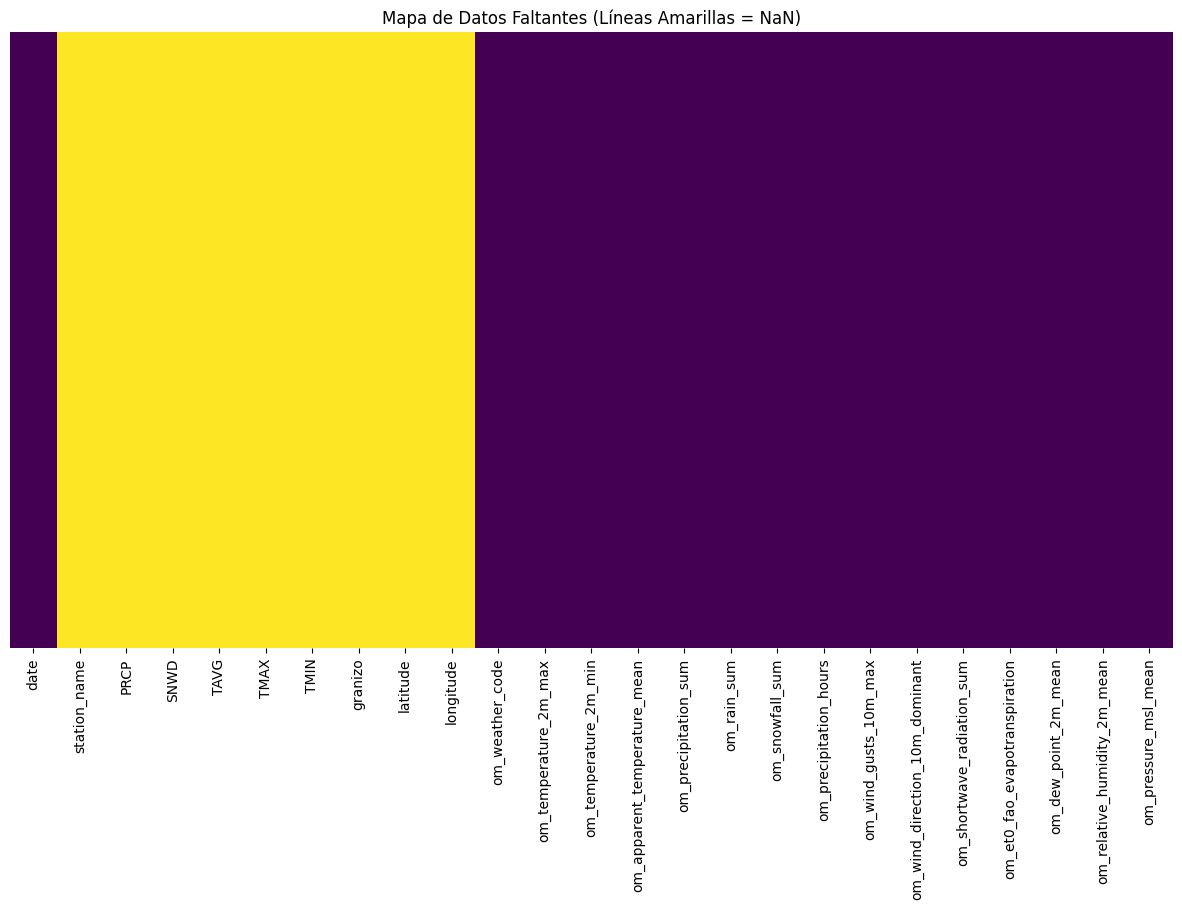

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Nos aseguramos de que el DataFrame exista antes de graficar
if 'df_unificado' in locals():
    plt.figure(figsize=(15, 8)) # Hacemos el gráfico más grande
    
    # Creamos un mapa de calor. cbar=False oculta la barra de color.
    # yticklabels=False oculta las etiquetas del eje Y para que sea más legible.
    sns.heatmap(df_unificado.isnull(), cbar=False, yticklabels=False, cmap='viridis')
    
    plt.title('Mapa de Datos Faltantes (Líneas Amarillas = NaN)')
    plt.show()

In [28]:
df_unificado.head()

,date,station_name,PRCP,SNWD,TAVG,TMAX,TMIN,granizo,latitude,longitude,...,om_rain_sum,om_snowfall_sum,om_precipitation_hours,om_wind_gusts_10m_max,om_wind_direction_10m_dominant,om_shortwave_radiation_sum,om_et0_fao_evapotranspiration,om_dew_point_2m_mean,om_relative_humidity_2m_mean,om_pressure_msl_mean
0,2000-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.6,0.0,4.0,34.92,217.95932,27.46,5.370969,10.142082,63.186707,1010.94586
1,2000-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.8,0.0,2.0,34.20,327.63907,29.82,5.576764,10.317083,65.937706,1011.46660
2,2000-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,0.0,6.0,29.88,127.30416,26.26,4.950904,8.635833,61.850185,1011.10834
3,2000-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,33.12,199.26538,31.92,6.207740,6.385833,51.514492,1009.44995
4,2000-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.3,0.0,3.0,49.32,23.77689,28.36,5.476084,8.685832,60.012115,1010.88324


Luego de ver que sucedieron errores en la descarga y luego la union se procede a descargar nuevamente los datos, pero solamente por estacion sin unir o demas.